# Jonathan Halverson
# Wednesday, May 4, 2016 (Updated Feb. 18, 2018)
# Loading and saving data

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("AppName").getOrCreate()

### Text files

In [3]:
# create an RDD of a string per line in the text file
lines = spark.read.text('text_file.md')
print lines.count()
print lines.first()

95
Row(value=u'# Apache Spark')


In [9]:
# example of treating a CSV file like a textfile
crimes = spark.read.text('Crime_Incident_Reports_no_header.csv')
knife = crimes.rdd.filter(lambda row: 'knife' in row.value.lower())
knife.take(2)

[Row(value=u'120419954,ALARMH,ROBBERY,03xx,B2,276,07/08/2012 04:36:00 PM,Knife,No,No,First,2012,7,Sunday,Part One,768918.0261,2946746.413,SHAWMUT AV,,"(42.33326635, -71.08299956)"'),
 Row(value=u'120420460,PKNIFE,AGGRAVATED ASSAULT,04xx,D14,755,07/08/2012 09:24:00 PM,Knife,No,No,First,2012,7,Sunday,Part One,744525.8777,2953176.035,TREMONT ST,,"(42.35120135, -71.17311952)"')]

In [8]:
crimes.filter(crimes.value.contains('Knife')).show(2)

+--------------------+
|               value|
+--------------------+
|120419954,ALARMH,...|
|120420460,PKNIFE,...|
+--------------------+
only showing top 2 rows



In [6]:
knife.saveAsTextFile('./saveAs')

In [13]:
# the key is the file name and value the contents of the file
input = spark.sparkContext.wholeTextFiles('text_files')
print input.count()
print input.collect()

2
[(u'file:/Users/jhalverson/data_science/spark/text_files/file1.txt', u'Cake\nPudding\nCupcakes\nIce cream\n'), (u'file:/Users/jhalverson/data_science/spark/text_files/file2.txt', u'David Bradshaw, 34, USA\nDug Williams, 44, USA\nChad Kneelville, 91, Brazil\n')]


In [14]:
input.mapValues(lambda line: line.split()).values().collect()

[[u'Cake', u'Pudding', u'Cupcakes', u'Ice', u'cream'],
 [u'David',
  u'Bradshaw,',
  u'34,',
  u'USA',
  u'Dug',
  u'Williams,',
  u'44,',
  u'USA',
  u'Chad',
  u'Kneelville,',
  u'91,',
  u'Brazil']]

Use saveAsTextFile for writing both CSV and JSON. Use the json.dumps method on each line, for instance.

### JSON

In [31]:
import json

In [33]:
with open('book.json', 'r') as f:
     data = json.load(f)
data

{u'glossary': {u'GlossDiv': {u'GlossList': {u'GlossEntry': {u'Abbrev': u'ISO 8879:1986',
     u'Acronym': u'SGML',
     u'GlossDef': {u'GlossSeeAlso': [u'GML', u'XML'],
      u'para': u'A meta-markup language, used to create markup languages such as DocBook.'},
     u'GlossSee': u'markup',
     u'GlossTerm': u'Standard Generalized Markup Language',
     u'ID': u'SGML',
     u'SortAs': u'SGML'}},
   u'title': u'S'},
  u'title': u'example glossary'}}

In [39]:
# to read JSON, it is best to read as the text file and then parse
lines = spark.read.text('person2.json')
print lines.count()

2


In [40]:
lines.show()

+--------------------+
|               value|
+--------------------+
|{"firstName": "Jo...|
|{"firstName": "Ji...|
+--------------------+



In [41]:
lines.printSchema()

root
 |-- value: string (nullable = true)



In [43]:
import json
data = lines.rdd.map(lambda row: json.loads(row.value))
print data.count()
print data.first()

2
{u'lastName': u'Smith', u'phoneNumbers': [{u'type': u'home', u'number': u'212 555-1234'}], u'firstName': u'John', u'address': {u'postalCode': u'10021', u'city': u'New York', u'state': u'NY'}}


In [44]:
data.filter(lambda x: x['lastName'] == 'Cutts').collect()

[{u'address': {u'city': u'Buffalo', u'postalCode': u'10541', u'state': u'NY'},
  u'firstName': u'Jimmy',
  u'lastName': u'Cutts',
  u'phoneNumbers': [{u'number': u'567 555-4991', u'type': u'home'}]}]

In [47]:
import csv
import StringIO

# approach works best when the header is removed from the csv file
header = ['COMPNOS', 'NatureCode', 'INCIDENT_TYPE_DESCRIPTION', 'MAIN_CRIMECODE', 'REPTDISTRICT',
          'REPORTINGAREA', 'FROMDATE', 'WEAPONTYPE', 'Shooting', 'DOMESTIC', 'SHIFT', 'Year',
          'Month', 'DAY_WEEK', 'UCRPART', 'X', 'Y', 'STREETNAME', 'XSTREETNAME', 'Location']
filename = '/Users/jhalverson/data_science/spark/Crime_Incident_Reports.csv'
filename = '/Users/jhalverson/data_science/spark/Crime_Incident_Reports_no_header.csv'
if 0:
     header = []
     filename = '/Users/jhalverson/data_science/spark/Crime_Incident_Reports_no_header.csv'

def loadRecord(line):
     sline = StringIO.StringIO(line)
     reader = csv.DictReader(sline, fieldnames=header)
     return reader.next()

crimes = spark.read.text(filename).rdd.map(loadRecord)
crimes.take(2)

[{'COMPNOS': "Row(value=u'120420285",
  'DAY_WEEK': 'Sunday',
  'DOMESTIC': 'No',
  'FROMDATE': '07/08/2012 06:00:00 AM',
  'INCIDENT_TYPE_DESCRIPTION': 'RESIDENTIAL BURGLARY',
  'Location': "(42.34638135, -71.10379454)')",
  'MAIN_CRIMECODE': '05RB',
  'Month': '7',
  'NatureCode': 'BERPTA',
  'REPORTINGAREA': '629',
  'REPTDISTRICT': 'D4',
  'SHIFT': 'Last',
  'STREETNAME': 'ABERDEEN ST',
  'Shooting': 'No',
  'UCRPART': 'Part One',
  'WEAPONTYPE': 'Other',
  'X': '763273.1791',
  'XSTREETNAME': '',
  'Y': '2951498.962',
  'Year': '2012'},
 {'COMPNOS': "Row(value=u'120419202",
  'DAY_WEEK': 'Sunday',
  'DOMESTIC': 'No',
  'FROMDATE': '07/08/2012 06:03:00 AM',
  'INCIDENT_TYPE_DESCRIPTION': 'AGGRAVATED ASSAULT',
  'Location': "(42.31684135, -71.07458456)')",
  'MAIN_CRIMECODE': '04xx',
  'Month': '7',
  'NatureCode': 'PSHOT ',
  'REPORTINGAREA': '327',
  'REPTDISTRICT': 'B2',
  'SHIFT': 'Last',
  'STREETNAME': 'HOWARD AV',
  'Shooting': 'Yes',
  'UCRPART': 'Part One',
  'WEAPONTYPE': 

In [52]:
crimes = spark.read.csv(filename, header=False, inferSchema=True)
crimes.show(10)

+---------+------+--------------------+---------+---+---+--------------------+-------+---+---+----+----+----+------+----------+-----------+-----------+-------------+--------------+--------------------+
|      _c0|   _c1|                 _c2|      _c3|_c4|_c5|                 _c6|    _c7|_c8|_c9|_c10|_c11|_c12|  _c13|      _c14|       _c15|       _c16|         _c17|          _c18|                _c19|
+---------+------+--------------------+---------+---+---+--------------------+-------+---+---+----+----+----+------+----------+-----------+-----------+-------------+--------------+--------------------+
|120420285|BERPTA|RESIDENTIAL BURGLARY|     05RB| D4|629|07/08/2012 06:00:...|  Other| No| No|Last|2012|   7|Sunday|  Part One|763273.1791|2951498.962|  ABERDEEN ST|          null|(42.34638135, -71...|
|120419202|PSHOT |  AGGRAVATED ASSAULT|     04xx| B2|327|07/08/2012 06:03:...|Firearm|Yes| No|Last|2012|   7|Sunday|  Part One|771223.1638|2940772.099|    HOWARD AV|          null|(42.31684135

In [57]:
from pyspark.sql import functions as F
crimes.groupby('_c7').agg(F.count('*')).show()

+--------------------+--------+
|                 _c7|count(1)|
+--------------------+--------+
|             Unarmed|  194932|
|                None|   11319|
|               Other|   52102|
|             Firearm|    5299|
|Personal Weapon (...|     282|
|               Knife|    3867|
|Knife/Cutting Ins...|     177|
|        Blunt Object|      78|
+--------------------+--------+



In [55]:
crimes.rdd.map(lambda x: x['_c7']).countByValue().items()

[(u'None', 11319),
 (u'Personal Weapon (hand  foot  etc.)', 282),
 (u'Knife/Cutting Instrument', 177),
 (u'Unarmed', 194932),
 (u'Other', 52102),
 (u'Blunt Object', 78),
 (u'Firearm', 5299),
 (u'Knife', 3867)]

In [67]:
rdd1 = spark.sparkContext.textFile("/Users/jhalverson/data_science/spark/Crime_Incident_Reports_no_header.csv")
rdd1 = rdd1.mapPartitions(lambda x: csv.reader(x))
print rdd1.take(3)

[['120420285', 'BERPTA', 'RESIDENTIAL BURGLARY', '05RB', 'D4', '629', '07/08/2012 06:00:00 AM', 'Other', 'No', 'No', 'Last', '2012', '7', 'Sunday', 'Part One', '763273.1791', '2951498.962', 'ABERDEEN ST', '', '(42.34638135, -71.10379454)'], ['120419202', 'PSHOT ', 'AGGRAVATED ASSAULT', '04xx', 'B2', '327', '07/08/2012 06:03:00 AM', 'Firearm', 'Yes', 'No', 'Last', '2012', '7', 'Sunday', 'Part One', '771223.1638', '2940772.099', 'HOWARD AV', '', '(42.31684135, -71.07458456)'], ['120419213', 'ARMROB', 'ROBBERY', '03xx', 'D4', '625', '07/08/2012 06:26:00 AM', 'Firearm', 'No', 'No', 'Last', '2012', '7', 'Sunday', 'Part One', '765118.8605', '2950217.536', 'JERSEY ST', 'QUEENSBERRY ST', '(42.34284135, -71.09698955)']]


In [70]:
weapons = rdd1.map(lambda x: x[7]).filter(lambda x: x != 'WEAPONTYPE').countByValue().items()
weapons

[('None', 11319),
 ('Personal Weapon (hand  foot  etc.)', 282),
 ('Knife/Cutting Instrument', 177),
 ('Unarmed', 194932),
 ('Other', 52102),
 ('Blunt Object', 78),
 ('Firearm', 5299),
 ('Knife', 3867)]

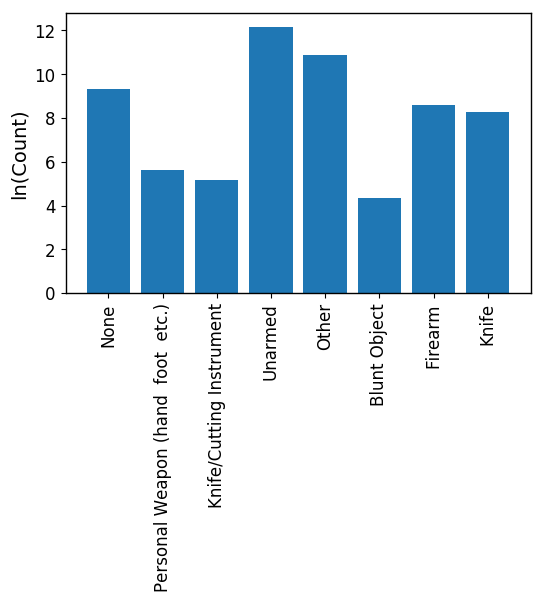

In [71]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

labels, counts = zip(*weapons)

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.bar(range(len(counts)), np.log(counts), align='center')
ax.set_xticklabels(labels)
plt.xticks(range(len(counts)), rotation='vertical')
plt.ylabel('ln(Count)')

### Hadoop sequence files

Good for writing key/value pairs. Can be read in parallel and are binary.

In [72]:
elk_sightings = spark.sparkContext.parallelize([('Frank', 4), ('Tony', 0), ('Catherine', 0)])
elk_sightings.saveAsSequenceFile('seqfiles')

In [74]:
data = spark.sparkContext.sequenceFile('seqfiles', 'org.apache.hadoop.io.Text', 'org.apache.hadoop.io.IntWritable')
data.collect()

[(u'Frank', 4), (u'Tony', 0), (u'Catherine', 0)]